In [1]:
import sf_quant.data as sfd

import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
import os
import tqdm

/home/msch2022/sf-quant-labs-1/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-23 13:42:08,836	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
start = dt.date(1970, 1, 1)
end = dt.date(2004, 1, 31)
columns = ["permno","cusip", "date" ,"prc", "ret", "vol", "shrout"]
data = sfd.load_crsp_monthly(
    start=start,
    end=end,
    columns=columns
)

In [3]:
def compute_satv(data: pl.DataFrame, window: int = 12) -> pl.DataFrame:
    """
    Compute Standardized Abnormal Turnover Volume (SATV)
    SATV_t = (turnover_t - mean(turnover_{t-12:t-2})) / std(turnover_{t-12:t-2})
    turnover = VOL / SHROUT
    window = 12 months
    """

    return (
        data.sort(["permno", "date"])
        .with_columns(
            (pl.col("vol") / pl.col("shrout")).alias("turnover")
        )
        .with_columns([
            # rolling stats INCLUDING current month
            pl.col("turnover")
            .rolling_mean(window)
            .over("permno")
            .alias("turnover_mean_raw"),

            pl.col("turnover")
            .rolling_std(window)
            .over("permno")
            .alias("turnover_std_raw"),
        ])
        .with_columns([
            # shift them so they do NOT include month t
            pl.col("turnover_mean_raw").shift(1).over("permno").alias("turnover_mean"),
            pl.col("turnover_std_raw").shift(1).over("permno").alias("turnover_std"),
        ])
        .with_columns(
            ((pl.col("turnover") - pl.col("turnover_mean")) / pl.col("turnover_std"))
            .alias("SATV")
        )
    )

data = compute_satv(data, window=12)

In [4]:
def compute_momentum(data: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the t-12 to t-2 momentum signal for each security (permno) and date.
    Matches monthmly CRSP data convention: 12-month cumulative return skipping most recent month.
    """
    return (
        data
        .sort(["permno", "date"])
        .with_columns(
            pl.when(pl.col("ret").is_not_null() & (pl.col("ret") > -1))
            .then((1 + pl.col("ret")).log())
            .otherwise(None)
            .alias("log_ret")
        )
        .with_columns(
            pl.col("log_ret")
            .rolling_sum(window_size=12)
            .over("permno")
            .alias("momentum")
        )
        .with_columns(
            pl.col("momentum").shift(1).over("permno")  # skip most recent month (t−1)
        )
    )

data = compute_momentum(data)


In [5]:
data = data.sort(["permno", "date"])

data = data.with_columns(
    pl.col("ret").shift(-1).over("permno").alias("ret_next")
)

data_clean = (
    data
    .filter(
        (pl.col("momentum").is_not_null()) &
        (pl.col("SATV").is_not_null()) &
        (pl.col("ret_next").is_not_null()) &
        (pl.col("prc") >= 5)
    )
)
data_clean

permno,cusip,date,prc,ret,vol,shrout,turnover,turnover_mean_raw,turnover_std_raw,turnover_mean,turnover_std,SATV,log_ret,momentum,ret_next
i64,str,date,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10001,"""36720410""",1987-02-27,6.25,-0.074074,365,991,0.368315,0.37582,0.181161,0.435398,0.272833,-0.245874,-0.076961,0.160325,0.0368
10001,"""36720410""",1987-03-31,6.375,0.0368,216,991,0.217962,0.365641,0.186697,0.37582,0.181161,-0.871369,0.036139,0.063161,-0.039216
10001,"""36720410""",1987-04-30,6.125,-0.039216,188,991,0.189707,0.362415,0.189596,0.365641,0.186697,-0.942352,-0.040006,0.074413,-0.071429
10001,"""36720410""",1987-05-29,5.6875,-0.071429,211,991,0.212916,0.361799,0.190111,0.362415,0.189596,-0.788512,-0.074108,0.024555,0.051429
10001,"""36720410""",1987-06-30,5.875,0.051429,146,991,0.147326,0.353941,0.197341,0.361799,0.190111,-1.128149,0.05015,-0.039702,0.021277
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93316,"""98960110""",1999-09-30,7.125,-0.167883,850,3082,0.275795,0.193395,0.153661,0.178594,0.153557,0.632997,-0.183782,0.037179,-0.035088
93316,"""98960110""",1999-10-29,6.875,-0.035088,185,3082,0.060026,0.155454,0.119317,0.193395,0.153661,-0.867944,-0.035718,-0.150384,0.236364
93316,"""98960110""",1999-11-30,8.5,0.236364,811,3082,0.263141,0.170823,0.120406,0.155454,0.119317,0.902532,0.212175,-0.035718,0.514706


In [6]:
data_clean = data_clean.with_columns([
    pl.col("SATV")
        .rank(method="dense")
        .over("date")
        .alias("satv_rank"),
    pl.len()
        .over("date")
        .alias("satv_count"),
])

data_clean = data_clean.with_columns(
    ((pl.col("satv_rank") - 1) / pl.col("satv_count") * 5)
        .cast(pl.Int8)
        .clip(0, 4)
        .alias("satv_q")
)


In [7]:
data_clean = data_clean.with_columns([
    pl.col("momentum")
        .rank(method="dense")
        .over("date")
        .alias("mom_rank"),
    pl.len()
        .over("date")
        .alias("mom_count"),
])

data_clean = data_clean.with_columns(
    ((pl.col("mom_rank") - 1) / pl.col("mom_count") * 5)
        .cast(pl.Int8)
        .clip(0, 4)
        .alias("mom_q")
)


In [8]:
data_clean = data_clean.with_columns(
    (pl.col("mom_q") * 5 + pl.col("satv_q"))
        .alias("port_id")
)


In [9]:
# number of stocks per (date, portfolio)
data_clean = data_clean.with_columns(
    pl.len()
    .over(["date", "port_id"])
    .alias("n_in_port")
)

# equal weights
data_clean = data_clean.with_columns(
    (1 / pl.col("n_in_port")).alias("weight")
)

data_clean


permno,cusip,date,prc,ret,vol,shrout,turnover,turnover_mean_raw,turnover_std_raw,turnover_mean,turnover_std,SATV,log_ret,momentum,ret_next,satv_rank,satv_count,satv_q,mom_rank,mom_count,mom_q,port_id,n_in_port,weight
i64,str,date,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32,i8,u32,u32,i8,i8,u32,f64
10001,"""36720410""",1987-02-27,6.25,-0.074074,365,991,0.368315,0.37582,0.181161,0.435398,0.272833,-0.245874,-0.076961,0.160325,0.0368,1685,3607,2,1782,3607,2,12,134,0.007463
10001,"""36720410""",1987-03-31,6.375,0.0368,216,991,0.217962,0.365641,0.186697,0.37582,0.181161,-0.871369,0.036139,0.063161,-0.039216,422,3635,0,1367,3635,1,5,129,0.007752
10001,"""36720410""",1987-04-30,6.125,-0.039216,188,991,0.189707,0.362415,0.189596,0.365641,0.186697,-0.942352,-0.040006,0.074413,-0.071429,497,3640,0,1568,3640,2,10,139,0.007194
10001,"""36720410""",1987-05-29,5.6875,-0.071429,211,991,0.212916,0.361799,0.190111,0.362415,0.189596,-0.788512,-0.074108,0.024555,0.051429,1270,3639,1,1526,3639,2,11,158,0.006329
10001,"""36720410""",1987-06-30,5.875,0.051429,146,991,0.147326,0.353941,0.197341,0.361799,0.190111,-1.128149,0.05015,-0.039702,0.021277,512,3697,0,1427,3697,1,5,164,0.006098
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
93316,"""98960110""",1999-09-30,7.125,-0.167883,850,3082,0.275795,0.193395,0.153661,0.178594,0.153557,0.632997,-0.183782,0.037179,-0.035088,3447,4436,3,1715,4436,1,8,144,0.006944
93316,"""98960110""",1999-10-29,6.875,-0.035088,185,3082,0.060026,0.155454,0.119317,0.193395,0.153661,-0.867944,-0.035718,-0.150384,0.236364,811,4337,0,1109,4337,1,5,202,0.00495
93316,"""98960110""",1999-11-30,8.5,0.236364,811,3082,0.263141,0.170823,0.120406,0.155454,0.119317,0.902532,0.212175,-0.035718,0.514706,3373,4408,3,1860,4408,2,13,154,0.006494


In [10]:
data_clean = data_clean.with_columns(
    pl.when((pl.col("ret_next").is_not_null()) & (pl.col("ret_next") > -1))
      .then((1 + pl.col("ret_next")).log())
      .otherwise(None)
      .alias("log_ret_next")
)

/tmp/ipykernel_3844390/1868063138.py:8: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(
/tmp/ipykernel_3844390/1868063138.py:27: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(


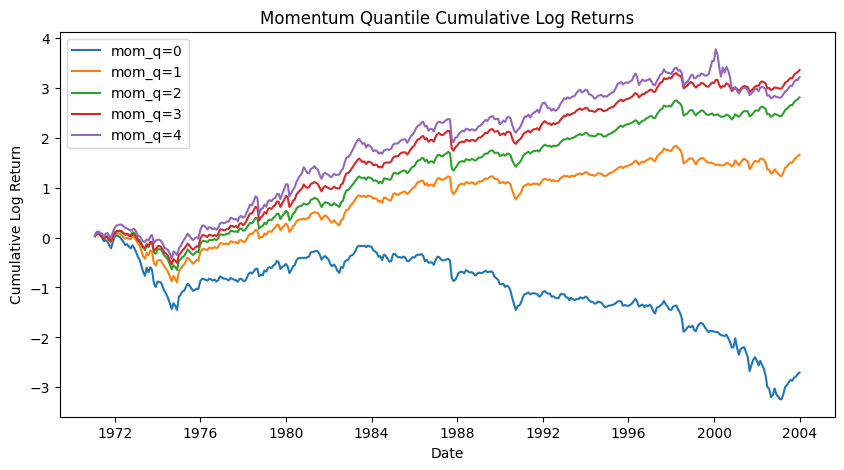

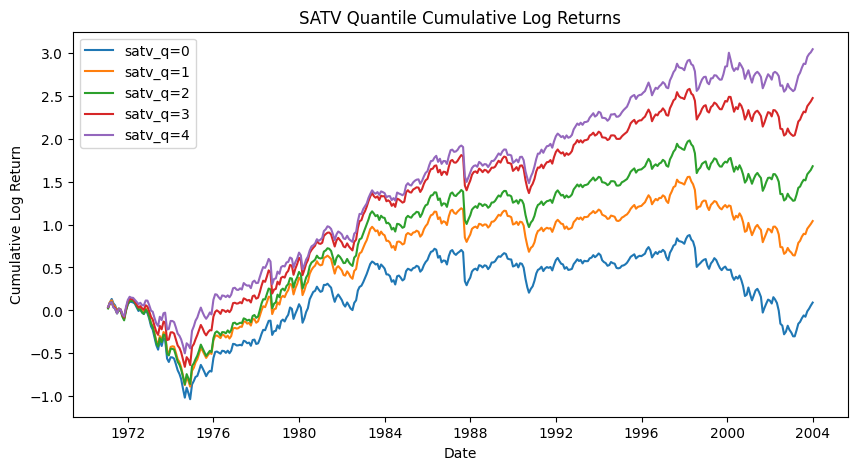

In [11]:
# -----------------------------------------------------------
# 2. Momentum quantile time series
# -----------------------------------------------------------
mom_ts = (
    data_clean
    .group_by(["date", "mom_q"])
    .agg(pl.col("log_ret_next").mean().alias("avg_log_ret"))
    .pivot(
        values="avg_log_ret",
        index="date",
        columns="mom_q"
    )
    .sort("date")
)

# cumulative log return arrays for plotting
mom_dates = mom_ts["date"].to_list()
mom_cum = [np.nancumsum(mom_ts[str(q)].to_numpy()) for q in range(5)]

# -----------------------------------------------------------
# 3. SATV quantile time series
# -----------------------------------------------------------
satv_ts = (
    data_clean
    .group_by(["date", "satv_q"])
    .agg(pl.col("log_ret_next").mean().alias("avg_log_ret"))
    .pivot(
        values="avg_log_ret",
        index="date",
        columns="satv_q"
    )
    .sort("date")
)

# cumulative log returns
satv_dates = satv_ts["date"].to_list()
satv_cum = [np.nancumsum(satv_ts[str(q)].to_numpy()) for q in range(5)]

# -----------------------------------------------------------
# 4. PLOTS
# -----------------------------------------------------------

# Momentum cumulative log return plot
plt.figure(figsize=(10,5))
for q in range(5):
    plt.plot(mom_dates, mom_cum[q], label=f"mom_q={q}")
plt.title("Momentum Quantile Cumulative Log Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.show()

# SATV cumulative log return plot
plt.figure(figsize=(10,5))
for q in range(5):
    plt.plot(satv_dates, satv_cum[q], label=f"satv_q={q}")
plt.title("SATV Quantile Cumulative Log Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.show()

In [12]:
portfolio_rets = (
    data_clean
    .group_by(["date", "port_id"])
    .agg(
        (pl.col("weight") * pl.col("ret_next")).sum().alias("port_ret")
    )
    .sort(["date", "port_id"])
)

portfolio_rets


date,port_id,port_ret
date,i8,f64
1971-01-29,0,0.05611
1971-01-29,1,0.087967
1971-01-29,2,0.02747
1971-01-29,3,0.057034
1971-01-29,4,0.072731
…,…,…
2003-12-31,20,0.080983
2003-12-31,21,0.071833
2003-12-31,22,0.098743


In [13]:
# Pivot to wide format: one column per portfolio (0..24)
port_wide = portfolio_rets.pivot(
    values="port_ret",
    index="date",
    on="port_id"
).sort("date")

# Compute log returns and cumulative sum
port_wide = port_wide.with_columns(
    [
        (1 + pl.col(str(pid))).log().cum_sum().alias(f"cumlog_{pid}")
        for pid in range(25)
    ]
)


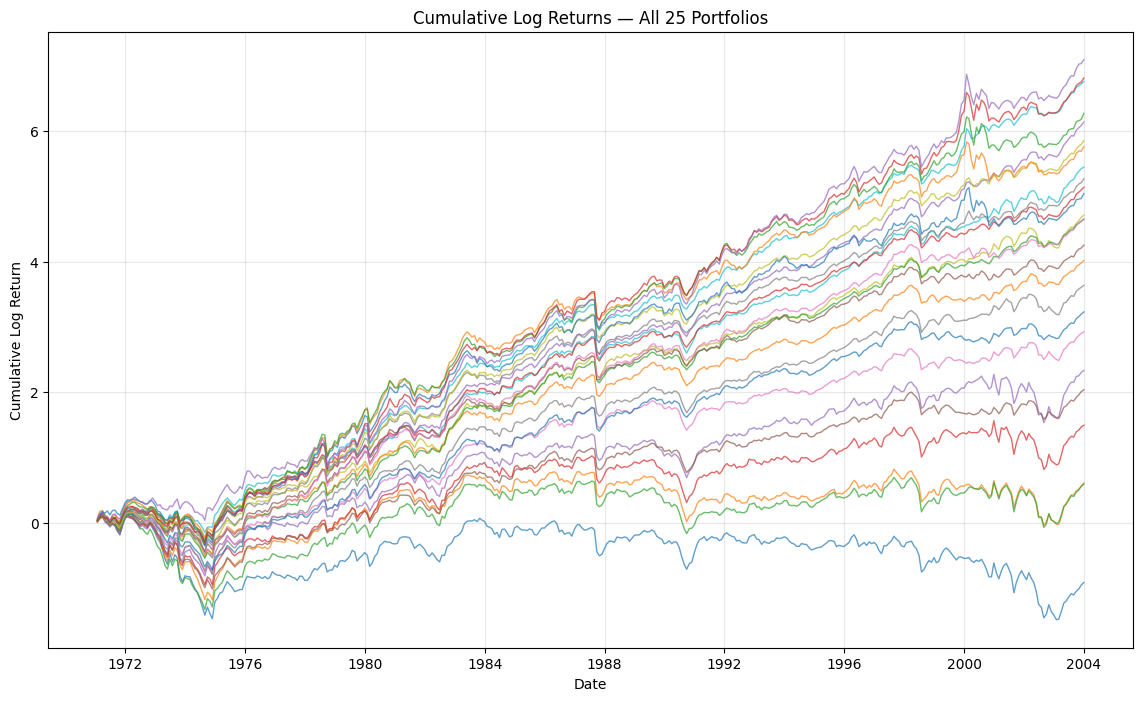

In [14]:
# Convert only the needed data to pandas for plotting
pdf = port_wide.select(
    ["date"] + [f"cumlog_{pid}" for pid in range(25)]
).to_pandas()

plt.figure(figsize=(14,8))

for pid in range(25):
    plt.plot(pdf["date"], pdf[f"cumlog_{pid}"], alpha=0.7, linewidth=1)

plt.title("Cumulative Log Returns — All 25 Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.grid(True, alpha=0.3)
plt.show()


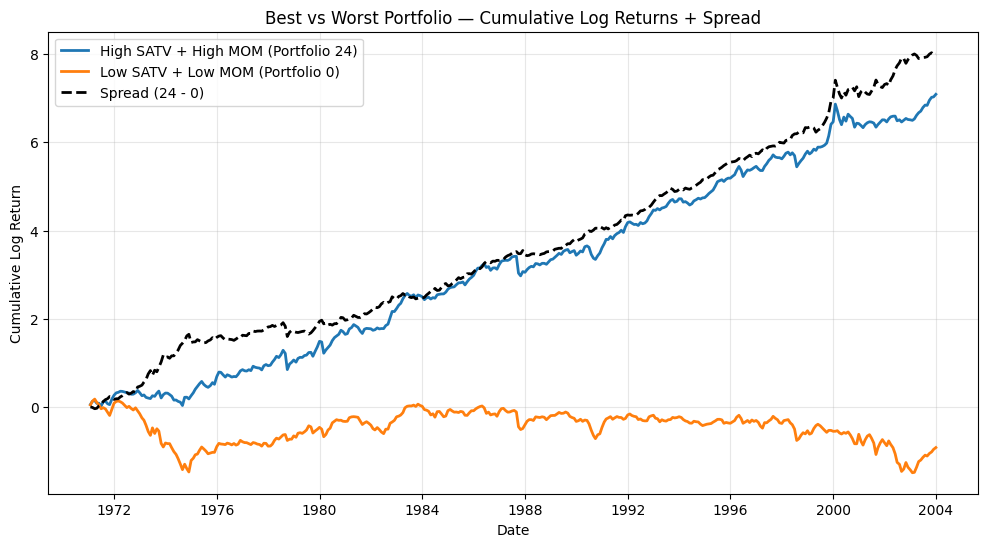

In [15]:
plt.figure(figsize=(12,6))

# Long leg
plt.plot(pdf["date"], pdf["cumlog_24"], label="High SATV + High MOM (Portfolio 24)", linewidth=2)

# Short leg
plt.plot(pdf["date"], pdf["cumlog_0"], label="Low SATV + Low MOM (Portfolio 0)", linewidth=2)

# Spread (24 - 0)
spread = pdf["cumlog_24"] - pdf["cumlog_0"]
plt.plot(pdf["date"], spread, label="Spread (24 - 0)", linewidth=2, linestyle="--", color="black")

plt.title("Best vs Worst Portfolio — Cumulative Log Returns + Spread")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



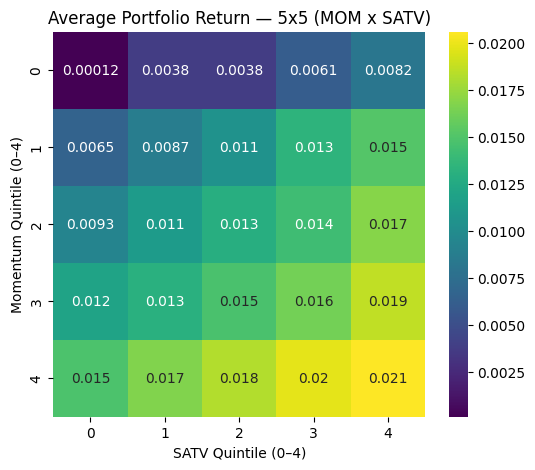

In [16]:
# Compute mean returns per portfolio
mean_rets = (
    portfolio_rets
    .group_by("port_id")
    .agg(pl.col("port_ret").mean().alias("mean_ret"))
    .sort("port_id")
)

# Convert to numpy
vals = mean_rets["mean_ret"].to_numpy()

# Reshape into 5x5 (mom x satv)
heatmap_vals = vals.reshape(5,5)

plt.figure(figsize=(6,5))
sns.heatmap(heatmap_vals, annot=True, cmap="viridis")
plt.title("Average Portfolio Return — 5x5 (MOM x SATV)")
plt.xlabel("SATV Quintile (0–4)")
plt.ylabel("Momentum Quintile (0–4)")
plt.show()


In [17]:
# Extract returns for portfolio 24 and 0
p24 = portfolio_rets.filter(pl.col("port_id") == 24)["port_ret"].to_numpy()
p00 = portfolio_rets.filter(pl.col("port_id") == 0)["port_ret"].to_numpy()

# Compute Sharpe ratios
def sharpe_ratio(r):
    mean_r = np.mean(r)
    std_r = np.std(r, ddof=1)
    return (mean_r * 12) / (std_r * np.sqrt(12))

sharpe_24 = sharpe_ratio(p24)
sharpe_00 = sharpe_ratio(p00)

print("Sharpe(High SATV × High MOM, Portfolio 24):", sharpe_24)
print("Sharpe(Low SATV × Low MOM, Portfolio 0):", sharpe_00)

# Long–Short returns
long_short = p24 - p00

sharpe_ls = sharpe_ratio(long_short)

print("Sharpe(Long–Short, HighHigh - LowLow):", sharpe_ls)

Sharpe(High SATV × High MOM, Portfolio 24): 1.000460614434941
Sharpe(Low SATV × Low MOM, Portfolio 0): 0.006060312592134448
Sharpe(Long–Short, HighHigh - LowLow): 1.249791686231681


**Regressions and checking wether or not satv does anything**

In [18]:
# -----------------------------------------------------------
# High MOM × High SATV (M4, S4)
# -----------------------------------------------------------
p_M4_S4 = (
    data_clean
    .filter((pl.col("mom_q") == 4) & (pl.col("satv_q") == 4))
    .group_by("date")
    .agg(pl.col("ret_next").mean().alias("ret_M4_S4"))
    .sort("date")
)

# -----------------------------------------------------------
# High MOM × Low SATV (M4, S0)
# -----------------------------------------------------------
p_M4_S0 = (
    data_clean
    .filter((pl.col("mom_q") == 4) & (pl.col("satv_q") == 0))
    .group_by("date")
    .agg(pl.col("ret_next").mean().alias("ret_M4_S0"))
    .sort("date")
)

# -----------------------------------------------------------
# Merge and compute long–short spread
# -----------------------------------------------------------
spread_M4 = (
    p_M4_S4
    .join(p_M4_S0, on="date", how="inner")
    .with_columns(
        (pl.col("ret_M4_S4") - pl.col("ret_M4_S0"))
        .alias("ret_spread")
    )
    .sort("date")
)

# -----------------------------------------------------------
# Sharpe ratio helper
# -----------------------------------------------------------
def sharpe_ratio(r):
    mean_r = np.mean(r)
    std_r = np.std(r, ddof=1)
    return (mean_r * 12) / (std_r * np.sqrt(12))

# Extract returns
spread_returns = spread_M4["ret_spread"].to_numpy()

# Sharpe
sharpe_M4 = sharpe_ratio(spread_returns)

print("Sharpe(M4,S4 − M4,S0):", sharpe_M4)


Sharpe(M4,S4 − M4,S0): 0.609648754892143


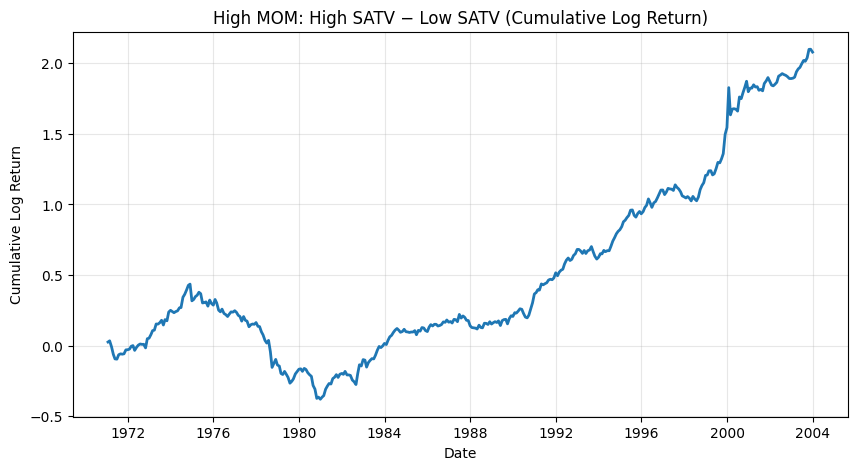

In [19]:
# -----------------------------------------------------------
# Cumulative log return plot
# -----------------------------------------------------------
cum_spread = np.nancumsum(np.log1p(spread_returns))

plt.figure(figsize=(10,5))
plt.plot(spread_M4["date"].to_list(), cum_spread, linewidth=2)
plt.title("High MOM: High SATV − Low SATV (Cumulative Log Return)")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.grid(alpha=0.3)
plt.show()
